# Fase 1: Preparación de los datos

## Importación de Librerías y Configuración

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib  # Para guardar el scaler y modelos clásicos
import os

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split

import os

# Para Deep Learning (LSTM)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical

# Configuración visual
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("Librerías importadas correctamente.")

Librerías importadas correctamente.


## Carga de Datos

In [2]:
# Definir nombres de columnas genéricos para TEP (52 variables)
# XMEAS (1-41) + XMV (1-11)
column_names = [f'XMEAS_{i}' for i in range(1, 42)] + [f'XMV_{i}' for i in range(1, 12)]

def load_tep_data(fault_range=range(0, 21), data_dir='../data/TEP_data'):
    """
    Carga los archivos d00.dat (train) y d00_te.dat (test), etc.
    Asigna la etiqueta de 'Fallo' correspondiente.
    """
    train_data = []
    test_data = []
    
    for fault_id in fault_range:
        # Formato de nombres de archivo (ajustar si es necesario)
        # Nota: d00 es normal, d01 es fallo 1, etc.
        # Rellenamos con ceros a la izquierda: d00, d01...
        file_id = f"{fault_id:02d}" 
        
        train_file = f"d{file_id}.dat"
        test_file = f"d{file_id}_te.dat"
        
        # Rutas completas
        path_train = os.path.join(data_dir, train_file)
        path_test = os.path.join(data_dir, test_file)
        
        # Cargar Train
        if os.path.exists(path_train):
            df_tr = pd.read_csv(path_train, sep='\s+', header=None, names=column_names)
            df_tr['fault'] = fault_id  # Etiqueta target
            df_tr['dataset'] = 'train'
            train_data.append(df_tr)
            print(f"Cargado Train: {train_file} | Shape: {df_tr.shape}")
            
        # Cargar Test
        if os.path.exists(path_test):
            df_te = pd.read_csv(path_test, sep='\s+', header=None, names=column_names)
            df_te['fault'] = fault_id  # Etiqueta target
            df_te['dataset'] = 'test'
            test_data.append(df_te)
            print(f"Cargado Test:  {test_file} | Shape: {df_te.shape}")

    # Concatenar todo
    df_train_final = pd.concat(train_data, ignore_index=True)
    df_test_final = pd.concat(test_data, ignore_index=True)
    
    return df_train_final, df_test_final

# --- EJECUCIÓN DE CARGA ---
# Asumiendo que los archivos están en la misma carpeta que el notebook
# Si usas Colab, sube los archivos y ajusta la ruta si es necesario.
df_train, df_test = load_tep_data(fault_range=range(0, 22)) # Solo cargamos fallos 0 a 4 por ahora

print("\nTotal Train:", df_train.shape)
print("Total Test:", df_test.shape)

Cargado Train: d00.dat | Shape: (52, 54)
Cargado Test:  d00_te.dat | Shape: (960, 54)
Cargado Train: d01.dat | Shape: (480, 54)
Cargado Test:  d01_te.dat | Shape: (960, 54)
Cargado Train: d02.dat | Shape: (480, 54)
Cargado Test:  d02_te.dat | Shape: (960, 54)
Cargado Train: d03.dat | Shape: (480, 54)
Cargado Test:  d03_te.dat | Shape: (960, 54)
Cargado Train: d04.dat | Shape: (480, 54)
Cargado Test:  d04_te.dat | Shape: (960, 54)
Cargado Train: d05.dat | Shape: (480, 54)
Cargado Test:  d05_te.dat | Shape: (960, 54)
Cargado Train: d06.dat | Shape: (480, 54)
Cargado Test:  d06_te.dat | Shape: (960, 54)
Cargado Train: d07.dat | Shape: (480, 54)
Cargado Test:  d07_te.dat | Shape: (960, 54)
Cargado Train: d08.dat | Shape: (480, 54)
Cargado Test:  d08_te.dat | Shape: (960, 54)
Cargado Train: d09.dat | Shape: (480, 54)
Cargado Test:  d09_te.dat | Shape: (960, 54)
Cargado Train: d10.dat | Shape: (480, 54)
Cargado Test:  d10_te.dat | Shape: (960, 54)
Cargado Train: d11.dat | Shape: (480, 54)
Ca

<>:28: SyntaxWarning: invalid escape sequence '\s'
<>:36: SyntaxWarning: invalid escape sequence '\s'
<>:28: SyntaxWarning: invalid escape sequence '\s'
<>:36: SyntaxWarning: invalid escape sequence '\s'
/var/folders/ql/chdr3tpx7pz4ftr0xxsf1sd80000gn/T/ipykernel_23629/2021749728.py:28: SyntaxWarning: invalid escape sequence '\s'
  df_tr = pd.read_csv(path_train, sep='\s+', header=None, names=column_names)
/var/folders/ql/chdr3tpx7pz4ftr0xxsf1sd80000gn/T/ipykernel_23629/2021749728.py:36: SyntaxWarning: invalid escape sequence '\s'
  df_te = pd.read_csv(path_test, sep='\s+', header=None, names=column_names)


Cargado Test:  d20_te.dat | Shape: (960, 54)
Cargado Train: d21.dat | Shape: (480, 54)
Cargado Test:  d21_te.dat | Shape: (960, 54)

Total Train: (10132, 54)
Total Test: (21120, 54)


## Limpieza y Normalización

In [3]:
# 1. Separar Features (X) y Target (y)
X_train = df_train.drop(['fault', 'dataset'], axis=1)
y_train = df_train['fault']

X_test = df_test.drop(['fault', 'dataset'], axis=1)
y_test = df_test['fault']

# 2. Normalización (StandardScaler)
# IMPORTANTE: El scaler se ajusta (fit) SOLO con train, y se aplica (transform) a train y test.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Guardamos el scaler para usarlo luego en la APP con BentoML
joblib.dump(scaler, 'tep_scaler.pkl')
print("Scaler guardado como 'tep_scaler.pkl'")

# Convertimos de nuevo a DataFrame para facilitar el EDA
X_train_df = pd.DataFrame(X_train_scaled, columns=column_names)
X_train_df['fault'] = y_train.values # Añadimos label para visualización

Scaler guardado como 'tep_scaler.pkl'


## EDA y Selección de Variables (PCA)

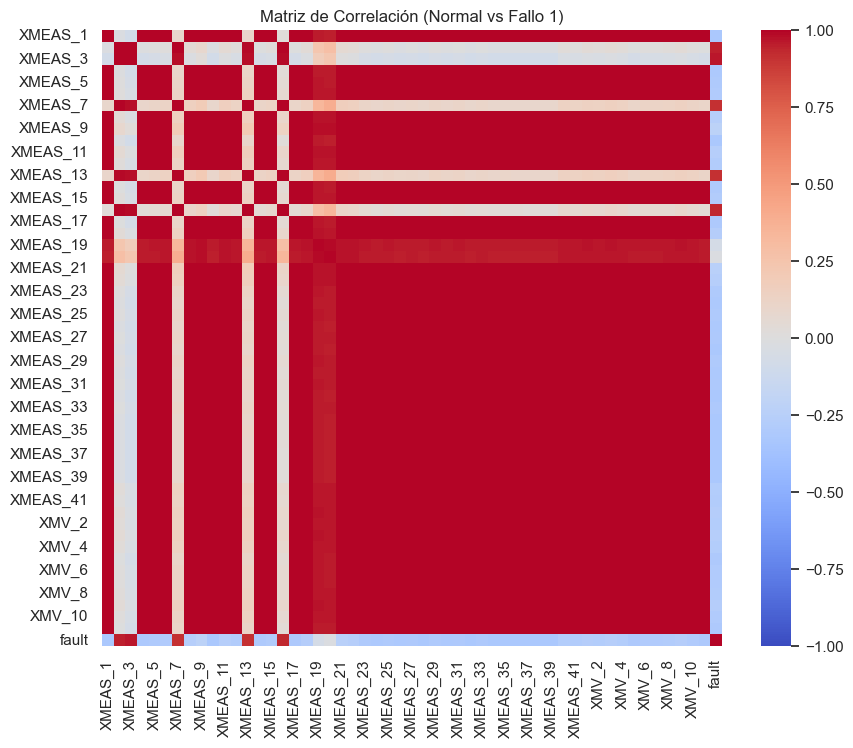

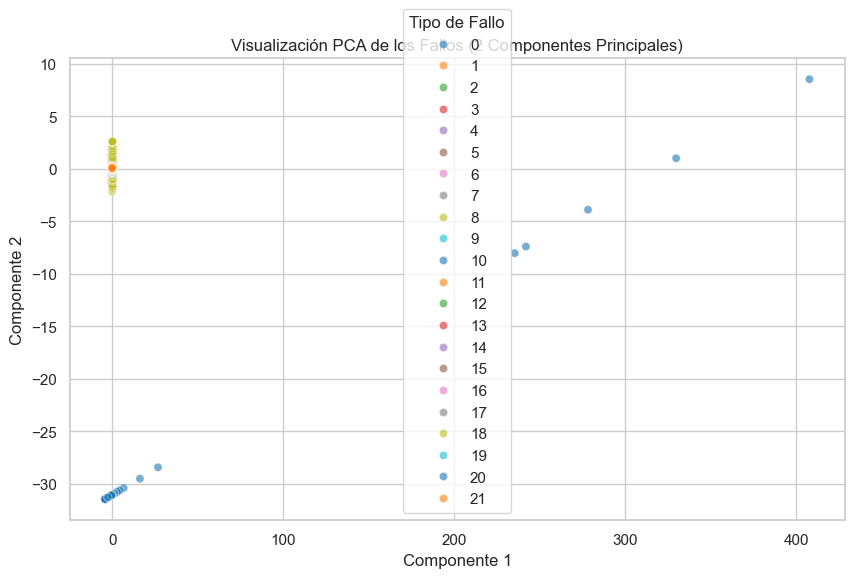

Varianza explicada por 2 componentes: 0.98


In [4]:
# 1. Matriz de Correlación (Solo para estado Normal vs Fallo 1 por ejemplo)
plt.figure(figsize=(10, 8))
subset = X_train_df[X_train_df['fault'].isin([0, 1])] # Comparamos Normal vs Fallo 1
sns.heatmap(subset.corr(), cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Matriz de Correlación (Normal vs Fallo 1)")
plt.show()

# 2. PCA para Visualización (Reducción a 2 dimensiones)
# ¿Se separan bien los fallos visualmente?
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_scaled)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=y_train, palette='tab10', alpha=0.6)
plt.title("Visualización PCA de los Fallos (2 Componentes Principales)")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.legend(title='Tipo de Fallo')
plt.show()

print(f"Varianza explicada por 2 componentes: {np.sum(pca.explained_variance_ratio_):.2f}")

## Feature Engineering (Ventanas de Tiempo para LSTM)

In [5]:
def create_sequences(X, y, time_steps=10):
    """
    Transforma datos 2D (muestras, features) a 3D (muestras, time_steps, features)
    """
    Xs, ys = [], []
    # Recorremos el array creando ventanas
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

TIME_STEPS = 10  # Usamos una ventana de 10 muestras anteriores

# Creamos las secuencias (Esto puede tardar un poco si hay muchos datos)
X_train_lstm, y_train_lstm = create_sequences(X_train_scaled, y_train.values, TIME_STEPS)
X_test_lstm, y_test_lstm = create_sequences(X_test_scaled, y_test.values, TIME_STEPS)

# One-hot encoding de las etiquetas para la red neuronal
num_classes = len(np.unique(y_train))
y_train_lstm_cat = to_categorical(y_train_lstm, num_classes=num_classes)
y_test_lstm_cat = to_categorical(y_test_lstm, num_classes=num_classes)

print(f"Shape para LSTM (Train): {X_train_lstm.shape}")
# Resultado esperado: (n_muestras, 10, 52)

Shape para LSTM (Train): (10122, 10, 52)


## Entrenamiento de Modelos y Comparativa

### Modelo 1: Random Forest

In [6]:
print("Entrenando Random Forest...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_scaled, y_train)

# Evaluación RF
y_pred_rf = rf_model.predict(X_test_scaled)
print("\n--- Reporte Random Forest ---")
print(classification_report(y_test, y_pred_rf))

# Guardar Modelo RF
joblib.dump(rf_model, 'tep_rf_model.pkl')

Entrenando Random Forest...

--- Reporte Random Forest ---
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       960
           1       0.99      0.82      0.90       960
           2       0.97      0.81      0.89       960
           3       0.11      0.23      0.15       960
           4       0.93      0.81      0.86       960
           5       0.61      0.53      0.57       960
           6       1.00      0.83      0.91       960
           7       1.00      0.83      0.91       960
           8       0.73      0.51      0.60       960
           9       0.12      0.18      0.14       960
          10       0.27      0.38      0.32       960
          11       0.83      0.56      0.67       960
          12       0.51      0.62      0.56       960
          13       0.83      0.18      0.30       960
          14       0.94      0.79      0.86       960
          15       0.09      0.28      0.14       960
          16       0.3

/Users/sara/Documents/deusto_2025_2026/Analítica de Datos para la Industria/ProyectoFinal_Grupo03/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/sara/Documents/deusto_2025_2026/Analítica de Datos para la Industria/ProyectoFinal_Grupo03/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/sara/Documents/deusto_2025_2026/Analítica de Datos para la Industria/ProyectoFinal_Grupo03/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1

['tep_rf_model.pkl']

### Modelo 2: LSTM

In [7]:
print("Entrenando LSTM...")

model_lstm = Sequential()
# Capa LSTM
model_lstm.add(LSTM(64, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]), return_sequences=False))
model_lstm.add(Dropout(0.2)) # Para evitar sobreajuste
# Capa densa de salida
model_lstm.add(Dense(num_classes, activation='softmax'))

model_lstm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenar (usamos pocas epochs para prueba rápida, sube a 10-20 para resultado real)
history = model_lstm.fit(
    X_train_lstm, y_train_lstm_cat,
    epochs=5,
    batch_size=64,
    validation_split=0.1,
    verbose=1
)

# Guardar Modelo LSTM (formato nuevo de keras)
model_lstm.save('tep_lstm_model.keras')
print("Modelo LSTM guardado.")

Entrenando LSTM...
Epoch 1/5


/Users/sara/Documents/deusto_2025_2026/Analítica de Datos para la Industria/ProyectoFinal_Grupo03/.venv/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.2440 - loss: 2.4665 - val_accuracy: 0.0000e+00 - val_loss: 6.2554
Epoch 2/5
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3861 - loss: 1.8440 - val_accuracy: 0.0000e+00 - val_loss: 7.8811
Epoch 3/5
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4774 - loss: 1.5835 - val_accuracy: 0.0000e+00 - val_loss: 8.2654
Epoch 4/5
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5332 - loss: 1.4000 - val_accuracy: 0.0000e+00 - val_loss: 9.2906
Epoch 5/5
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5697 - loss: 1.2838 - val_accuracy: 0.0000e+00 - val_loss: 9.7013
Modelo LSTM guardado.


## Evaluación y Matriz de Confusión

660/660 ━━━━━━━━━━━━━━━━━━━━ 1s 796us/step


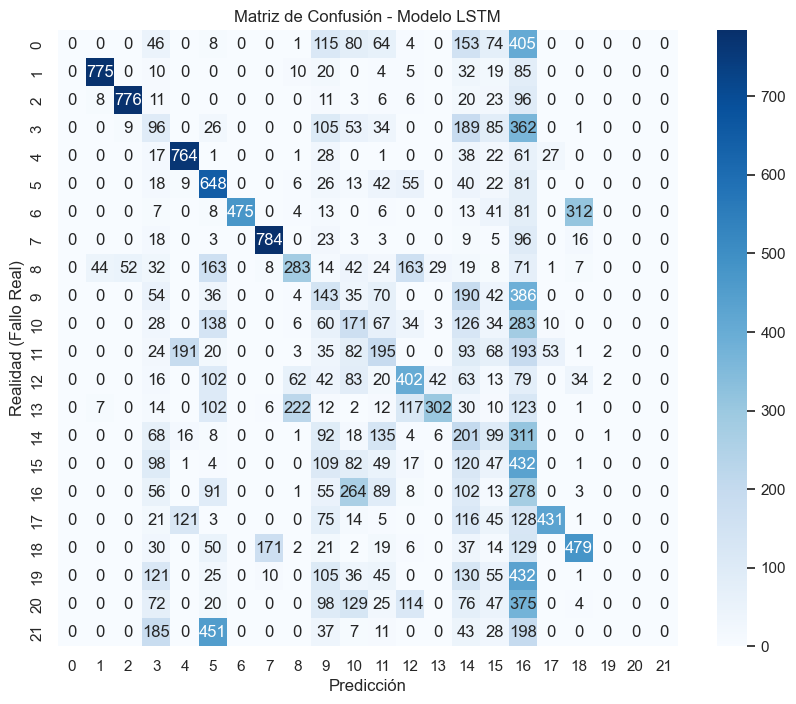

F1-Score Random Forest: 0.5587
F1-Score LSTM: 0.3469


In [8]:
# Predicciones LSTM
y_pred_lstm_prob = model_lstm.predict(X_test_lstm)
y_pred_lstm = np.argmax(y_pred_lstm_prob, axis=1)

# Matriz de Confusión (Usando LSTM como ejemplo principal)
cm = confusion_matrix(y_test_lstm, y_pred_lstm)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusión - Modelo LSTM")
plt.xlabel("Predicción")
plt.ylabel("Realidad (Fallo Real)")
plt.show()

# Comparativa rápida
f1_rf = f1_score(y_test, y_pred_rf, average='weighted')
f1_lstm = f1_score(y_test_lstm, y_pred_lstm, average='weighted')

print(f"F1-Score Random Forest: {f1_rf:.4f}")
print(f"F1-Score LSTM: {f1_lstm:.4f}")